In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from lhereader import LHEReader
from itertools import islice
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from HiggstrahlungClassifier import *

In [128]:
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
### Import Files, convert LHE --> pd dataframe    ###
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
bkg_file = "Datasets/ee_Zbb_noH.lhe"
sig_file = "Datasets/ee_ZH_Zbb.lhe"

smear = 0.1;
df_bkg = MakeDF_bbZ(bkg_file, smear)
df_sig = MakeDF_bbZ(sig_file, smear)

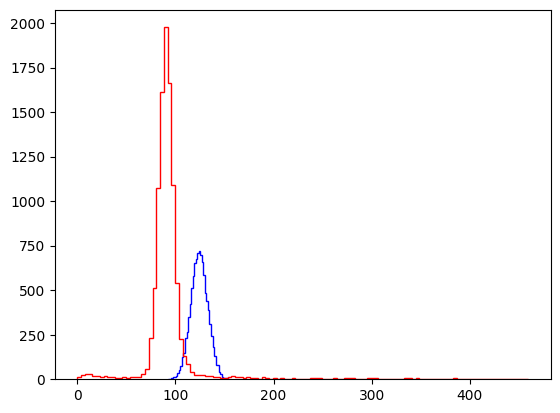

In [129]:
plt.hist(df_sig['m_bb'], bins=40, histtype='step', color='b');
plt.hist(df_bkg['m_bb'], bins=120, histtype='step', color='r');
# plt.yscale('log')

In [130]:
df_sig

,m_bb,px_Z,py_Z,pz_Z,E_Z,px_b1,py_b1,pz_b1,E_b1,px_b2,py_b2,pz_b2,E_b2
0,127.697128,-54.483132,-83.768607,201.484103,242.686395,49.494609,86.390659,-61.466272,117.103608,4.988524,-2.622053,-140.017831,140.209998
1,115.143652,95.905675,-103.365653,-175.215052,242.688941,-106.610367,50.698835,164.138824,202.236954,10.704692,52.666818,11.076227,55.074104
2,130.170537,-138.360995,-165.363326,-63.987169,242.689933,81.812471,166.482459,22.305460,186.893855,56.548524,-1.119133,41.681708,70.416212
3,110.648268,-123.804104,-184.438714,35.197744,242.691631,-12.121588,-4.036898,-20.254832,24.404460,135.925692,188.475612,-14.942911,232.903909
4,126.484249,190.692101,9.701216,118.849510,242.689201,-144.528356,42.038015,-47.978965,158.049712,-46.163745,-51.739231,-70.870544,99.261087
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,126.492068,120.697477,166.996752,-90.153773,242.690648,-116.432853,-149.233041,118.423970,223.323613,-4.264624,-17.763712,-28.270196,33.985739
9996,123.587418,-206.888041,71.164921,52.116154,242.690034,159.569506,-38.430230,19.466621,165.349174,47.318535,-32.734691,-71.582775,91.960793
9997,121.527683,-100.555874,111.303250,167.578443,242.688449,104.112494,-131.303101,-166.745523,236.444655,-3.556620,19.999851,-0.832921,20.866896
9998,132.073322,-214.555983,-48.362292,47.012327,242.690320,212.842765,75.006676,-39.232065,229.105410,1.713218,-26.644384,-7.780262,28.204269


In [133]:
df_sig_nombb = df_sig.drop(columns=['m_bb'])
df_bkg_nombb = df_bkg.drop(columns=['m_bb'])

In [144]:
ae = HiggsAE(df_sig, df_bkg, 100, 64, 1e-4, 
             weight_decay=0, latent=4, layers_and_nodes=[32, 32, 8]);
ae.fit()
# ae_nombb.fit()

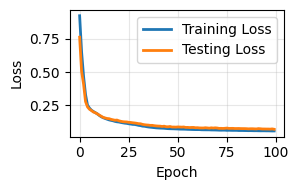

In [145]:
ae.plot_loss(train=True, test=True)

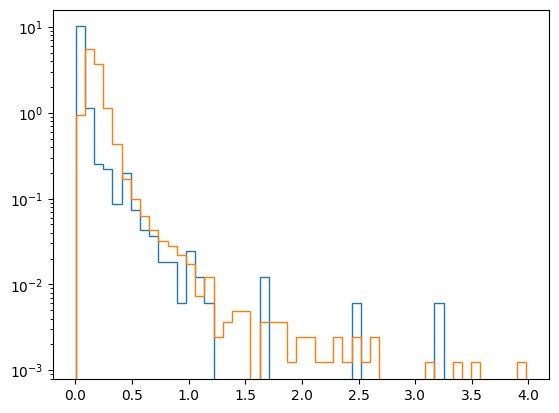

In [146]:
b_scores, s_scores = ae.predict_scores()
bins = np.linspace(
    min(b_scores.min(), s_scores.min()),
    max(b_scores.max(), s_scores.max()),
    50
)

plt.hist(b_scores, bins = bins, histtype='step', density = True);
plt.hist(s_scores, bins = bins, histtype='step', density = True);
plt.yscale('log')

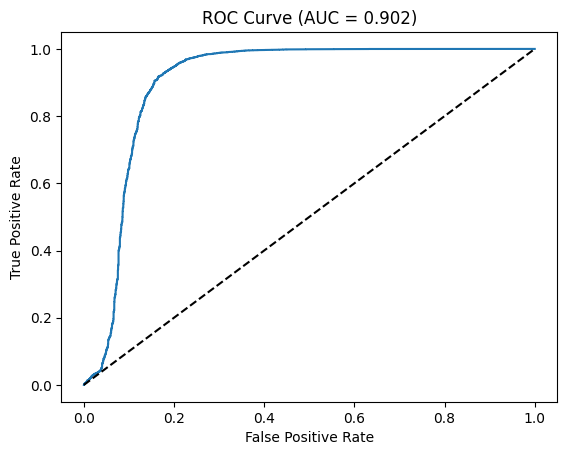

In [147]:
## ROC Curve ## 

y = np.concatenate([np.zeros_like(b_scores), np.ones_like(s_scores)])
scores = np.concatenate([b_scores, s_scores])

fpr, tpr, _ = roc_curve(y, scores)
auc = roc_auc_score(y, scores)
plt.plot(fpr, tpr);
plt.plot([0,1],[0,1],'k--');

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {auc:.3f})");

# Scaling Laws

In [148]:
def count_params(d_input, layers_and_nodes, latent):
    # full layer sequence: input → hidden layers → latent → decoder → output
    layer_sizes = [d_input] + layers_and_nodes + [latent] + list(reversed(layers_and_nodes)) + [d_input]
    return sum((layer_sizes[i] + 1) * layer_sizes[i+1] for i in range(len(layer_sizes)-1))

In [150]:
aes = []; 
# layers_and_nodes_s = [
#     [8],
#     [32],
#     [32, 8],
#     [32, 8, 8],
#     [32, 32, 8, 8], 
#     [32, 32, 32, 8, 8], 
#     [32, 32, 32, 32, 8, 8],
#     [32, 32, 32, 32, 32, 8, 8],
#     [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 8, 8],
# ]

# layers_and_nodes_s = [ 
#     [4], [5], [6], [7],        
#     [8], [9],          
#     [8, 4],        
#     [16, 8],       
#     [16, 8, 4],    
#     [32, 8],   
# ]

layers_and_nodes_s = [
    [4 ,  4], [8 ,  8], [12, 12], [16, 16], 
    [24, 24], [32, 32], [64, 64], [96, 96], [128, 128]
]

# layers_and_nodes_s = [
#     [8] * i for i in range(1, 10)
# ]

print(layers_and_nodes_s)


lat = 2;

for layers_and_nodes in layers_and_nodes_s:
    N_params = count_params(13, layers_and_nodes, lat)
    LR = 1e-1/np.sqrt(N_params)
    print(f'learning rate is {LR}')
    ae = HiggsAE(df_sig, df_bkg, epochs=50,
             batch_size=128, lr=LR, weight_decay=1e-4, latent=lat, 
             layers_and_nodes=layers_and_nodes)
    aes.append((ae, ae.nparams()))

[[4, 4], [8, 8], [12, 12], [16, 16], [24, 24], [32, 32], [64, 64], [96, 96], [128, 128]]
learning rate is 0.007392212709545729
learning rate is 0.00490880693673816
learning rate is 0.0037502930030867466
learning rate is 0.0030556616567607043
learning rate is 0.0022456322822201028
learning rate is 0.0017814588639398525
learning rate is 0.0009813830956902597
learning rate is 0.000678672241393843
learning rate is 0.0005189294113304032


In [151]:
params = [p for (_, p) in aes]
models = [m for (m, _) in aes]

In [152]:
aucs, train_losses, test_losses = [], [], []
n_repeats = 5

for m in models:
    auc_runs, train_loss_runs, test_loss_runs = [], [], []
    for r in range(n_repeats):
        m.fit()
        b_scores, s_scores = m.predict_scores()
        y = np.concatenate([np.zeros_like(b_scores), np.ones_like(s_scores)])
        scores = np.concatenate([b_scores, s_scores])
        auc_runs.append(roc_auc_score(y, scores))
        train_loss_runs.append(np.mean(m.train_losses[-5:])) 
        test_loss_runs.append(np.mean(m.test_losses[-5:])) 
    aucs.append(np.mean(auc_runs))
    train_losses.append(np.mean(train_loss_runs))
    test_losses.append(np.mean(test_loss_runs))

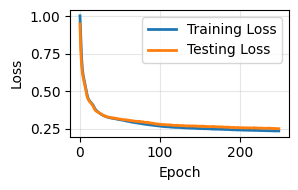

In [155]:
models[2].plot_loss(train=True, test=True)

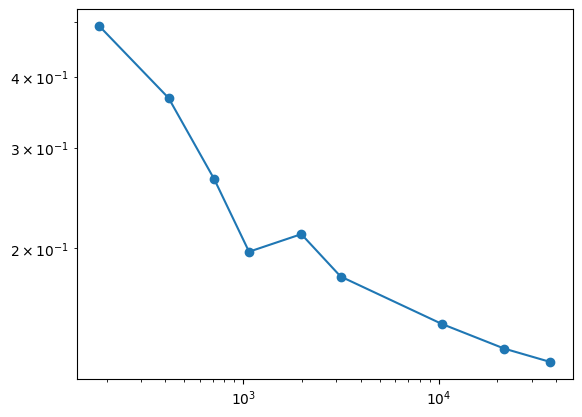

In [156]:
# plt.scatter(params, aucs);
# plt.plot(params, aucs);
plt.scatter(params, train_losses);
plt.plot(params, train_losses)
# plt.scatter(params, test_losses);
# plt.plot(params, test_losses)

alpha=0.4
# plt.plot(params, np.array(params)**(-alpha)*np.exp(-4.4))

plt.xscale('log')
plt.yscale('log')

α = 0.241 ± 0.031,  A = 1.388e+00,  R² = 0.895


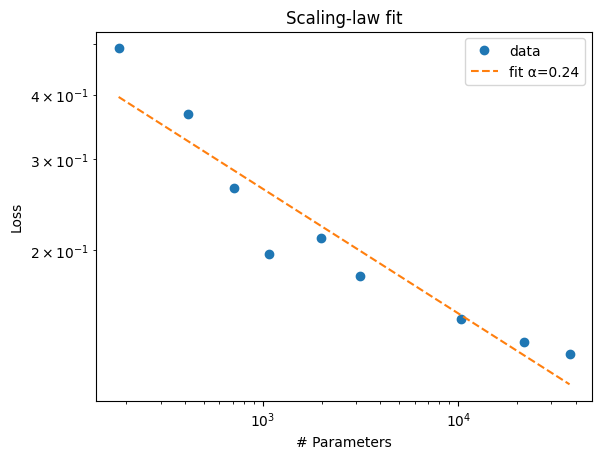

In [157]:
x = np.log(params)
y = np.log(train_losses)
slope, intercept, r, _, std_err = linregress(x, y)

alpha = -slope
A = np.exp(intercept)
print(f"α = {alpha:.3f} ± {std_err:.3f},  A = {A:.3e},  R² = {r**2:.3f}")

plt.loglog(params, train_losses, 'o', label='data')
plt.loglog(params, A * np.array(params)**(-alpha), '--', label=f'fit α={alpha:.2f}')
plt.legend()
plt.xlabel('# Parameters')
plt.ylabel('Loss')
plt.title('Scaling-law fit')
plt.show()